(example_3)=
# Example 3: A multi-armed bandit task with independent rewards and punishments

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_2_Input_node_volatility_coupling.ipynb)

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install pyhgf watermark

In [2]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from jax import grad, jit, vjp
from jax.tree_util import Partial
from pyhgf.distribution import HGFDistribution
from pyhgf.math import binary_surprise
from pyhgf.model import HGF
from pytensor.graph import Apply, Op
from scipy.stats import norm

np.random.seed(123)

In this notebook, we are going to illustrate how to fit behavioural responses from a two-armed bandit task when the rewards and punishments are independent using a task similar to what was used in {cite:p}`Pulcu2017` (see {ref}`task`). This will also illustrate how we can use missing/unobserved values in an input node, the impact this has on the belief trajectories, and how to deal with models where the decisions of the agent influence the observations.

```{figure} https://iiif.elifesciences.org/lax/27879%2Felife-27879-fig1-v3.tif/full/1500,/0/default.jpg
---
name: task
---
Experimental design

In the task considered here, two armed bandits are presented to the participant on each trial, and the participant has to select one of them to get the reward and punishments associated. In our simulation, we generalize further and consider that for both arms, the rewards and punishments are independent, which means that the participant has to infer four probabilities: $\{P(reward|A), P(loss|A), P(reward|B), P(loss|B)\}$. Because the rewards and punishments are independent, we simulate the task using four binary HGFs. Figure from {cite:p}`Pulcu2017`.
```

```{note}
While the binary HGF is a special case of the categorical HGF where the number of categories is set to 2, the categorical HGF assumes that only one category is presented on every trial, which is different from what we have here as on some trials, we could have both reward and loss on both arms. Also, a categorical HGF adds a volatility coupling between the binary branch (see {ref}`categorical_hgf`). Therefore, this model would not be suitable here as we want every branch of the network to evolve independently.
```

In [3]:
# the tonic volatility used across the tutorial
# this value is the same for four branches of the network
tonic_volatility = -1.5

We start by creating a network that consists in four two-levels HGF. Each branch is evolving independently and is not affecting the beliefs trajectories of other branches.

Initializing a network with custom node structure.


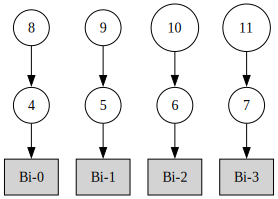

In [4]:
two_armed_bandit_hgf = (
    HGF(model_type=None)
    .add_nodes(kind="binary-input", n_nodes=4)
    .add_nodes(kind="binary-state", value_children=0)
    .add_nodes(kind="binary-state", value_children=1)
    .add_nodes(kind="binary-state", value_children=2)
    .add_nodes(kind="binary-state", value_children=3)
    .add_nodes(value_children=4, tonic_volatility=tonic_volatility)
    .add_nodes(value_children=5, tonic_volatility=tonic_volatility)
    .add_nodes(value_children=6, tonic_volatility=tonic_volatility)
    .add_nodes(value_children=7, tonic_volatility=tonic_volatility)
)
two_armed_bandit_hgf.plot_network()

## Task structure
We start with a simple task structure where contingencies (i.e. the probability that a given armed bandit is associated with a win/loss) alternate between `0.2`, `0.5` and `0.8`. The rate of change in contingencies can be fast (i.e. high volatility blocks) or slow (i.e. low volatility blocks).

In [5]:
# three levels of contingencies
high_prob, chance, low_prob = 0.8, 0.5, 0.2

# create blocks of contingencies
stable_contingencies = np.array([low_prob, high_prob]).repeat(40)
volatile_contingencies = np.tile(np.array([low_prob, high_prob]).repeat(10), 6)
chance_contingencies = np.array(chance).repeat(80)

In [6]:
# create sequences of blocks for each arm/rewards
win_arm1 = np.concatenate(
    [stable_contingencies, chance_contingencies, volatile_contingencies]
)
loss_arm1 = np.concatenate(
    [volatile_contingencies, chance_contingencies, stable_contingencies]
)
win_arm2 = np.concatenate(
    [chance_contingencies, stable_contingencies, volatile_contingencies]
)
loss_arm2 = np.concatenate(
    [chance_contingencies, volatile_contingencies, stable_contingencies]
)

In [7]:
# sample trial level outcomes from the sequences
u_win_arm1 = np.random.binomial(n=1, p=win_arm1)
u_loss_arm1 = np.random.binomial(n=1, p=loss_arm1)
u_win_arm2 = np.random.binomial(n=1, p=win_arm2)
u_loss_arm2 = np.random.binomial(n=1, p=loss_arm2)

This gives the following task structure:

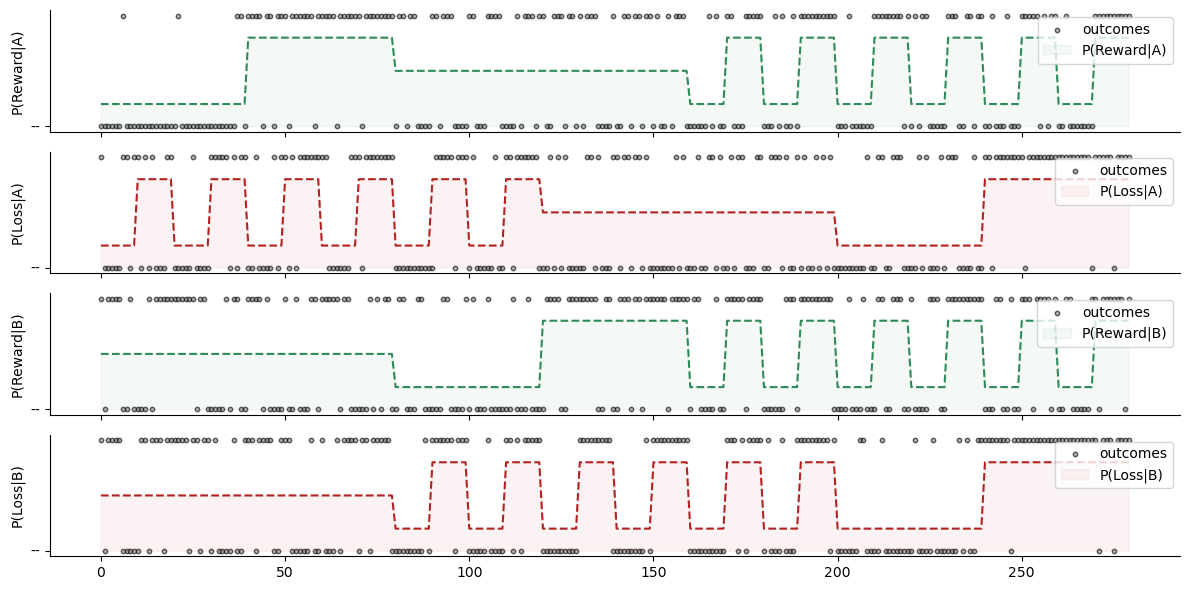

In [8]:
# trial numbers
trials = np.arange(len(win_arm1))

_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

for i, u, p, label, color in zip(
    range(4),
    [u_win_arm1, u_loss_arm1, u_win_arm2, u_loss_arm2],
    [win_arm1, loss_arm1, win_arm2, loss_arm2],
    ["P(Reward|A)", "P(Loss|A)", "P(Reward|B)", "P(Loss|B)"],
    ["seagreen", "firebrick", "seagreen", "firebrick"],
):
    axs[i].scatter(
        trials, u, label="outcomes", alpha=0.6, s=10, color="gray", edgecolor="k"
    )
    axs[i].plot(trials, p, "--", color=color)
    axs[i].fill_between(trials, p, "--", label=label, color=color, alpha=0.05)
    axs[i].legend(loc="upper right")
    axs[i].set_ylabel(label)
plt.tight_layout()
sns.despine();

## Simulate a dataset

We can simulate a vector of observation. This is a two-dimensional matrix with input observations for the four components of our model.

In [9]:
u = np.array([u_win_arm1, u_loss_arm1, u_win_arm2, u_loss_arm2])

From there, it is straightforward to feed these observations to our four branches to get an estimate of the trajectories.

```{note}
Here, we are providing all the outcomes from all trials. This is not how the task would work as the participant will only be presented with the outcomes from the armed bandit chosen, and we are not using responses from the participant yet. See also {ref}`custom_response_functions` for details on the observations `u` and the responses `y`.
```

In [10]:
two_armed_bandit_hgf.input_data(input_data=u.T);

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


... Create the update sequence from the network structure.
... Create the belief propagation function.
Adding 280 new observations.


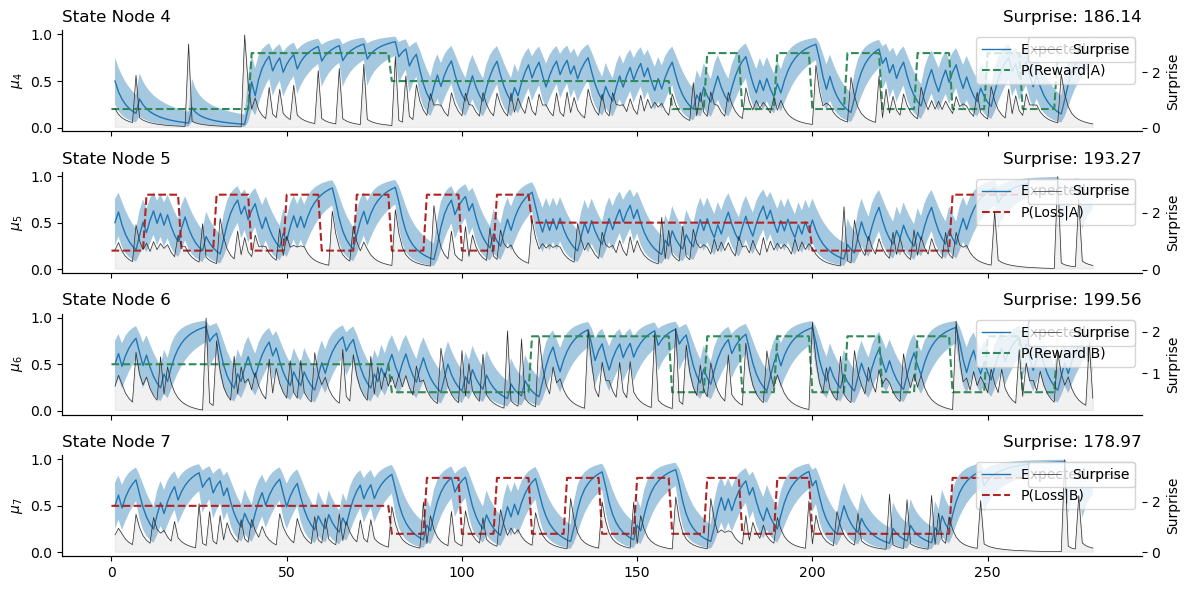

In [11]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_armed_bandit_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_armed_bandit_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_armed_bandit_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_armed_bandit_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [win_arm1, loss_arm1, win_arm2, loss_arm2],
    ["P(Reward|A)", "P(Loss|A)", "P(Reward|B)", "P(Loss|B)"],
    ["seagreen", "firebrick", "seagreen", "firebrick"],
):
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend(loc="upper right")

plt.tight_layout()
sns.despine();

## Simulate responses from a participant
Using the beliefs trajectories recovered from the model fits above, we can simulate responses from a participant that would use the same parametrisation of beliefs update (especially the same `tonic_volatility` here).

### Decision rule

The probability of chosing the arm $A$ given the expected probabilities of wining on both arms ${W_a; W_b}$ and the expected probabilities of loosing on both arms ${L_a; L_b}$, is given by the following softmax decision function:

$$
p(A) = \frac{e^{\beta(W_a-L_a)}}{e^{\beta(W_a-L_a)} + e^{\beta(W_b-L_b)}}
$$

where $\beta$ is the inverse temperature parameter.

In [12]:
beta = 1.0  # temperature parameter
w_a = two_armed_bandit_hgf.node_trajectories[4]["expected_mean"]
l_a = two_armed_bandit_hgf.node_trajectories[5]["expected_mean"]
w_b = two_armed_bandit_hgf.node_trajectories[6]["expected_mean"]
l_b = two_armed_bandit_hgf.node_trajectories[7]["expected_mean"]

p_a = np.exp(beta * (w_a - l_a)) / (
    np.exp(beta * (w_a - l_a)) + np.exp(beta * (w_b - l_b))
)

Using these probabilities, we can infer which arm was selected at each trial and filter the inputs that are presented to the participant. Because it would be too chaotic to provide the information about the four hidden states at each trial, here the participant is only presented with the information about the arm that was selected. Therefore, when arm $A$ is selected, the inputs from arm $B$ are hidden.

```{note}
Input nodes can receive missing or unobserved values. Missing inputs are used to indicate an absence of observation from the agent's point of view and should not be used for missing records or excluded trials. When an input is labelled as missing, we use the total volatility at the parents' level to decrease their precision as a function of time elapsed, but the mean of the belief is still the same. This behaviour accounts for the fact that the Gaussian Random Walk continues while no observations are made and the uncertainty increases accordingly. It could be assumed that there is also a limit to this behaviour and that the uncertainty will not increase infinitely. AR1 nodes are good candidates as volatility parents to implement this behaviour. 
```

In [13]:
# a new matrix of observations
missing_inputs_u = u.astype(float)

# create a mask to filter the observations using the agent's decisions
observed = np.ones(u.shape)
observed[:2, p_a <= 0.5] = 0
observed[2:, p_a > 0.5] = 0

Initializing a network with custom node structure.


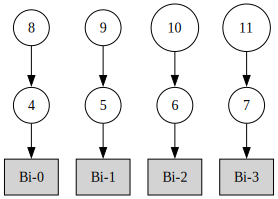

In [14]:
two_armed_bandit_missing_inputs_hgf = (
    HGF(model_type=None)
    .add_nodes(kind="binary-input", n_nodes=4)
    .add_nodes(kind="binary-state", value_children=0)
    .add_nodes(kind="binary-state", value_children=1)
    .add_nodes(kind="binary-state", value_children=2)
    .add_nodes(kind="binary-state", value_children=3)
    .add_nodes(value_children=4, tonic_volatility=tonic_volatility)
    .add_nodes(value_children=5, tonic_volatility=tonic_volatility)
    .add_nodes(value_children=6, tonic_volatility=tonic_volatility)
    .add_nodes(value_children=7, tonic_volatility=tonic_volatility)
)
two_armed_bandit_missing_inputs_hgf.plot_network()

In [15]:
# note that we are providing the mask as parameter of the input function
two_armed_bandit_missing_inputs_hgf.input_data(
    input_data=missing_inputs_u.T,
    observed=observed.T,
);

... Create the update sequence from the network structure.
... Create the belief propagation function.
Adding 280 new observations.


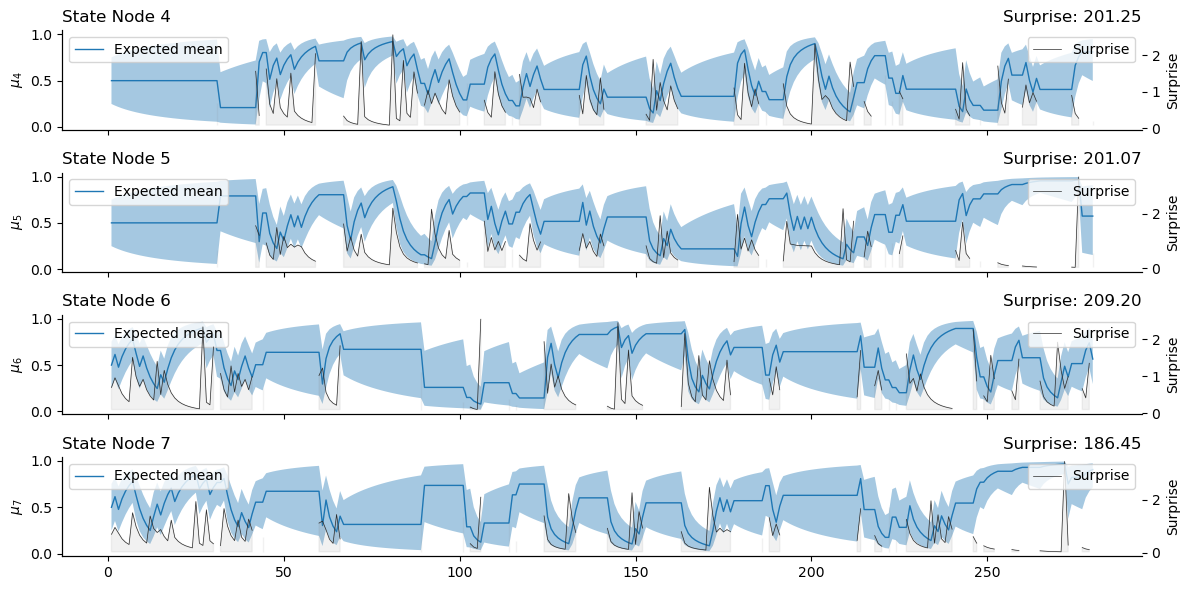

In [16]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_armed_bandit_missing_inputs_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_armed_bandit_missing_inputs_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_armed_bandit_missing_inputs_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_armed_bandit_missing_inputs_hgf.plot_nodes(node_idxs=7, axs=axs[3])

plt.tight_layout()
sns.despine();

We can now see from the plot above that the branches of the networks are only updated if the participant actually chose the corresponding arm. Otherwise, the expected probability remains the same but the uncertainty will increase over time.

## Parameter recovery

Now that we have set a model with the required number of branches, and allowed this model to observe missing inputs, we can simulate responses from a participant and try to recover the parameters of interest (here focusing on the tonic volatility at the second level). It should be noted here that this kind of model implies that the decisions of the agent directly influence the observations, as only the outcomes from the selected armed bandit are presented to the participant. This implies that - in the context of simulations - we cannot iterate over the whole batch of observations before estimating the decision function, and should instead compute every step sequentially in a for loop. This is an important difference as most of the models discussed in the other tutorials filter all the observations first, and then compute the response costs, as the two processes are not influencing each other.

### Real-time decision and belief updating

We can implement this process using the {py:func}`pyhgf.networks.beliefs_propagation` function. In other models, this step is called sequentially in a {py:func}`jax.lax.scan` loop, but we can also use it for a single-step update.

In [17]:
from pyhgf.utils import beliefs_propagation

In [18]:
two_armed_bandit_missing_inputs_hgf = (
    HGF(model_type=None, verbose=False)
    .add_nodes(kind="binary-input", n_nodes=4)
    .add_nodes(kind="binary-state", value_children=0)
    .add_nodes(kind="binary-state", value_children=1)
    .add_nodes(kind="binary-state", value_children=2)
    .add_nodes(kind="binary-state", value_children=3)
    .add_nodes(value_children=4, tonic_volatility=tonic_volatility)
    .add_nodes(value_children=5, tonic_volatility=tonic_volatility)
    .add_nodes(value_children=6, tonic_volatility=tonic_volatility)
    .add_nodes(value_children=7, tonic_volatility=tonic_volatility)
).create_belief_propagation_fn()

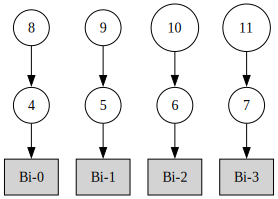

In [19]:
two_armed_bandit_missing_inputs_hgf.plot_network()

In [20]:
# get the network variables from the HGF class
attributes, structure, update_sequence = two_armed_bandit_missing_inputs_hgf.get_network()

In [21]:
input_data = u.astype(float).T
responses = []  # 1: arm A - 0: arm B

# for each observation
for i in range(input_data.shape[0]):

    # the observation mask - default to 1
    observed = np.ones(4)

    # the time elapsed between two trials - defaults to 1
    time_steps = np.ones(1)

    # the expectations about the outcomes
    w_a = attributes[4]["expected_mean"]
    l_a = attributes[5]["expected_mean"]
    w_b = attributes[6]["expected_mean"]
    l_b = attributes[7]["expected_mean"]

    # the decision function
    p_a = np.exp(beta * (w_a - l_a)) / (
        np.exp(beta * (w_a - l_a)) + np.exp(beta * (w_b - l_b))
    )

    # sample a decision using the probability
    response = np.random.binomial(p=p_a, n=1)
    responses.append(response)

    # hide the observations that were not selected
    if response:
        observed[2:] = 0
    else:
        observed[:2] = 0

    # update the probabilistic network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        input_data=(input_data[i], time_steps, observed),
        update_sequence=update_sequence,
        structure=structure,
    )
responses = jnp.asarray(responses)  # vector of responses

### Bayesian inference

Using the responses simulated above, we can try to recover the value of the tonic volatility. First, we start by creating the response function we want to optimize (see also {ref}`custom_response_functions` on how to create such functions).

In [22]:
# create a mask to hide the observations from the arm that was not selected by the participant
observed = np.ones(input_data.shape)
observed[2:, responses] = 0
observed[:2, ~responses] = 0

In [23]:
def two_bandits_logp(tonic_volatility, hgf, input_data, responses, observed):

    # replace with a new omega in the model
    hgf.attributes[8]["tonic_volatility"] = tonic_volatility
    hgf.attributes[9]["tonic_volatility"] = tonic_volatility
    hgf.attributes[10]["tonic_volatility"] = tonic_volatility
    hgf.attributes[11]["tonic_volatility"] = tonic_volatility

    # run the model forward
    hgf.input_data(input_data=input_data, observed=observed)

    # probabilities of choosing arm A
    beta = 1.0
    w_a = hgf.node_trajectories[4]["expected_mean"]
    l_a = hgf.node_trajectories[5]["expected_mean"]
    w_b = hgf.node_trajectories[6]["expected_mean"]
    l_b = hgf.node_trajectories[7]["expected_mean"]
    p_a = jnp.exp(beta * (w_a - l_a)) / (
        jnp.exp(beta * (w_a - l_a)) + jnp.exp(beta * (w_b - l_b))
    )

    # binary surprise given this probability
    surprise = jnp.sum(binary_surprise(responses, p_a))

    # the surprise of the model is the sum of binary surprise at all input level
    # plus the binary surprise for the agent decision
    surprise += jnp.sum(hgf.node_trajectories[0]["surprise"])
    surprise += jnp.sum(hgf.node_trajectories[1]["surprise"])
    surprise += jnp.sum(hgf.node_trajectories[2]["surprise"])
    surprise += jnp.sum(hgf.node_trajectories[3]["surprise"])

    surprise = jnp.where(jnp.isnan(surprise), jnp.inf, surprise)
    return -surprise

```{hint}
The response function computes the sum of the binary surprise (see {py:func}`pyhgf.math.binary_surprise`) at the first level of the four binary HGFs, and adds the binary surprise for the observed decision given the probabilities predicted by the sigmoid decision rule. While we are mostly interested in predicting the latter (and could use solely this quantity for optimization), this can produce situations where the binary HGFs are forced toward *extreme* beliefs in a way that overfit the responses from the participant. Adding their surprise in the equation ensures that these situations are limited, as such trajectories are also associated with extreme surprise. As always, we return the negative surprise to get a log probability that can be manipulated by PyMC.
```

We create both a jitted version of this function and the vector-jacobian product (gradient) requiered for a custom Op in PyTensor:

In [24]:
logp_fn = Partial(
    two_bandits_logp,
    hgf=two_armed_bandit_missing_inputs_hgf,
    input_data=input_data,
    responses=responses,
    observed=observed,
)

In [25]:
jitted_custom_op_jax = jit(logp_fn)


def vjp_custom_op_jax(x, gz):
    _, vjp_fn = vjp(logp_fn, x)
    return vjp_fn(gz)[0]


jitted_vjp_custom_op_jax = jit(vjp_custom_op_jax)

The log probability function and the gradient of this function are then passed to a new `Op`, which is a class that can be manipulated inside PyMC graphs.

In [26]:
# The CustomOp needs `make_node`, `perform` and `grad`.
class CustomOp(Op):
    def make_node(self, x):
        # Create a PyTensor node specifying the number and type of inputs and outputs

        # We convert the input into a PyTensor tensor variable
        inputs = [pt.as_tensor_variable(x)]
        # Output has the same type and shape as `x`
        outputs = [inputs[0].type()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        # Evaluate the Op result for a specific numerical input

        # The inputs are always wrapped in a list
        (x,) = inputs
        result = jitted_custom_op_jax(x)
        # The results should be assigned in place to the nested list
        # of outputs provided by PyTensor. If you have multiple
        # outputs and results, you should assign each at outputs[i][0]
        outputs[0][0] = np.asarray(result, dtype="float64")

    def grad(self, inputs, output_gradients):
        # Create a PyTensor expression of the gradient
        (x,) = inputs
        (gz,) = output_gradients
        # We reference the VJP Op created below, which encapsulates
        # the gradient operation
        return [vjp_custom_op(x, gz)]


class VJPCustomOp(Op):
    def make_node(self, x, gz):
        # Make sure the two inputs are tensor variables
        inputs = [pt.as_tensor_variable(x), pt.as_tensor_variable(gz)]
        # Output has the shape type and shape as the first input
        outputs = [inputs[0].type()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (x, gz) = inputs
        result = jitted_vjp_custom_op_jax(x, gz)
        outputs[0][0] = np.asarray(result, dtype="float64")


# Instantiate the Ops
custom_op = CustomOp()
vjp_custom_op = VJPCustomOp()

We are now ready to sample the model and estimate the value of tonic volatility.

In [27]:
with pm.Model() as model:
    omega = pm.Normal("omega", -4.0, 5)
    pm.Potential("hgf", custom_op(omega))
    idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [omega]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


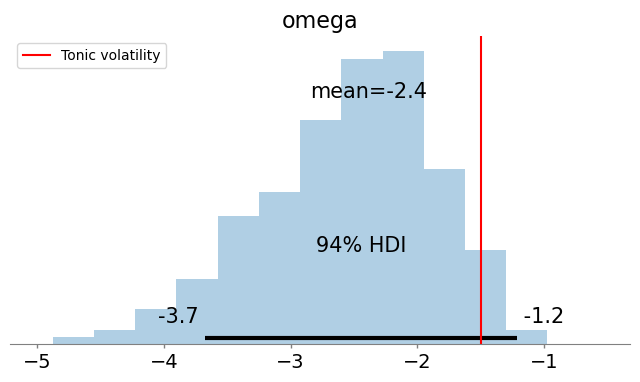

In [28]:
_, ax = plt.subplots(figsize=(8, 4))
az.plot_posterior(idata, ax=ax, kind="hist")
ax.axvline(tonic_volatility, color="r", label="Tonic volatility")
plt.legend();

## System configuration

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Thu May 23 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.23.0

pyhgf : 0.0.16
jax   : 0.4.27
jaxlib: 0.4.27

numpy     : 1.26.0
seaborn   : 0.13.2
jax       : 0.4.27
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
pymc      : 5.15.0
pytensor  : 2.20.0
matplotlib: 3.8.4
arviz     : 0.18.0

Watermark: 2.4.3

